In [3]:
import PIL
import pickle
import os
import numpy as np
import torch
import lpips
import torch.nn as nn
import torchvision.transforms as transforms
from pytorch_msssim import ms_ssim
from tqdm import tqdm
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
from torchvision.utils import make_grid
from torchvision.utils import save_image

import os
import sys
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
sys.path.append('./stylegan2-ada-pytorch/')

In [4]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.__version__)


True
12.4
2.6.0+cu124


## Скачиваем изображения и векторы

In [5]:
landmarks_model_path = "./stylegan2-ada-pytorch/pretrained_models/shape_predictor_68_face_landmarks.dat"
RAW_IMAGES_DIR = "./data/celebs"
ALIGNED_IMAGES_DIR = "./data/aligned_images"

# Align images

In [6]:
from stylegan2_models.image_aligner.face_alignment import image_align
from stylegan2_models.image_aligner.landmarks_detector import LandmarksDetector

landmarks_detector = LandmarksDetector(landmarks_model_path)
for celeb in os.listdir(RAW_IMAGES_DIR):
  celeb_folder = os.path.join(RAW_IMAGES_DIR, celeb)
  save_path = os.path.join(ALIGNED_IMAGES_DIR, celeb)
  os.makedirs(save_path, exist_ok=True)
  for i, img_name in enumerate(os.listdir(celeb_folder)):
      if img_name == ".ipynb_checkpoints":
        continue
      raw_img_path = os.path.join(celeb_folder, img_name)
      for face_landmarks in landmarks_detector.get_landmarks(raw_img_path):
          aligned_face_path = os.path.join(save_path, f"{i}.jpg")
          image_align(raw_img_path, aligned_face_path, face_landmarks)
          break

In [7]:
def display_aligned_images(aligned_images_dir, num_images=10):
    """
    Displays aligned images in a grid using matplotlib.

    Parameters:
        aligned_images_dir (str): Path to the directory containing aligned images.
        num_images (int): Number of images to display per person.
    """
    people = os.listdir(aligned_images_dir)
    # people.remove('.ipynb_checkpoints')

    fig, axes = plt.subplots(len(people), num_images, figsize=(15, len(people)*3))
    fig.suptitle("Aligned Images", fontsize=16)

    for row, person in enumerate(people):
        person_dir = os.path.join(aligned_images_dir, person)
        images = os.listdir(person_dir)[:num_images]

        for col, img_name in enumerate(images):
            img_path = os.path.join(person_dir, img_name)
            img = Image.open(img_path)

            if len(people) > 1:
                axes[row, col].imshow(img)
                axes[row, col].axis("off")
            else:
                axes[col].imshow(img)
                axes[col].axis("off")

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()


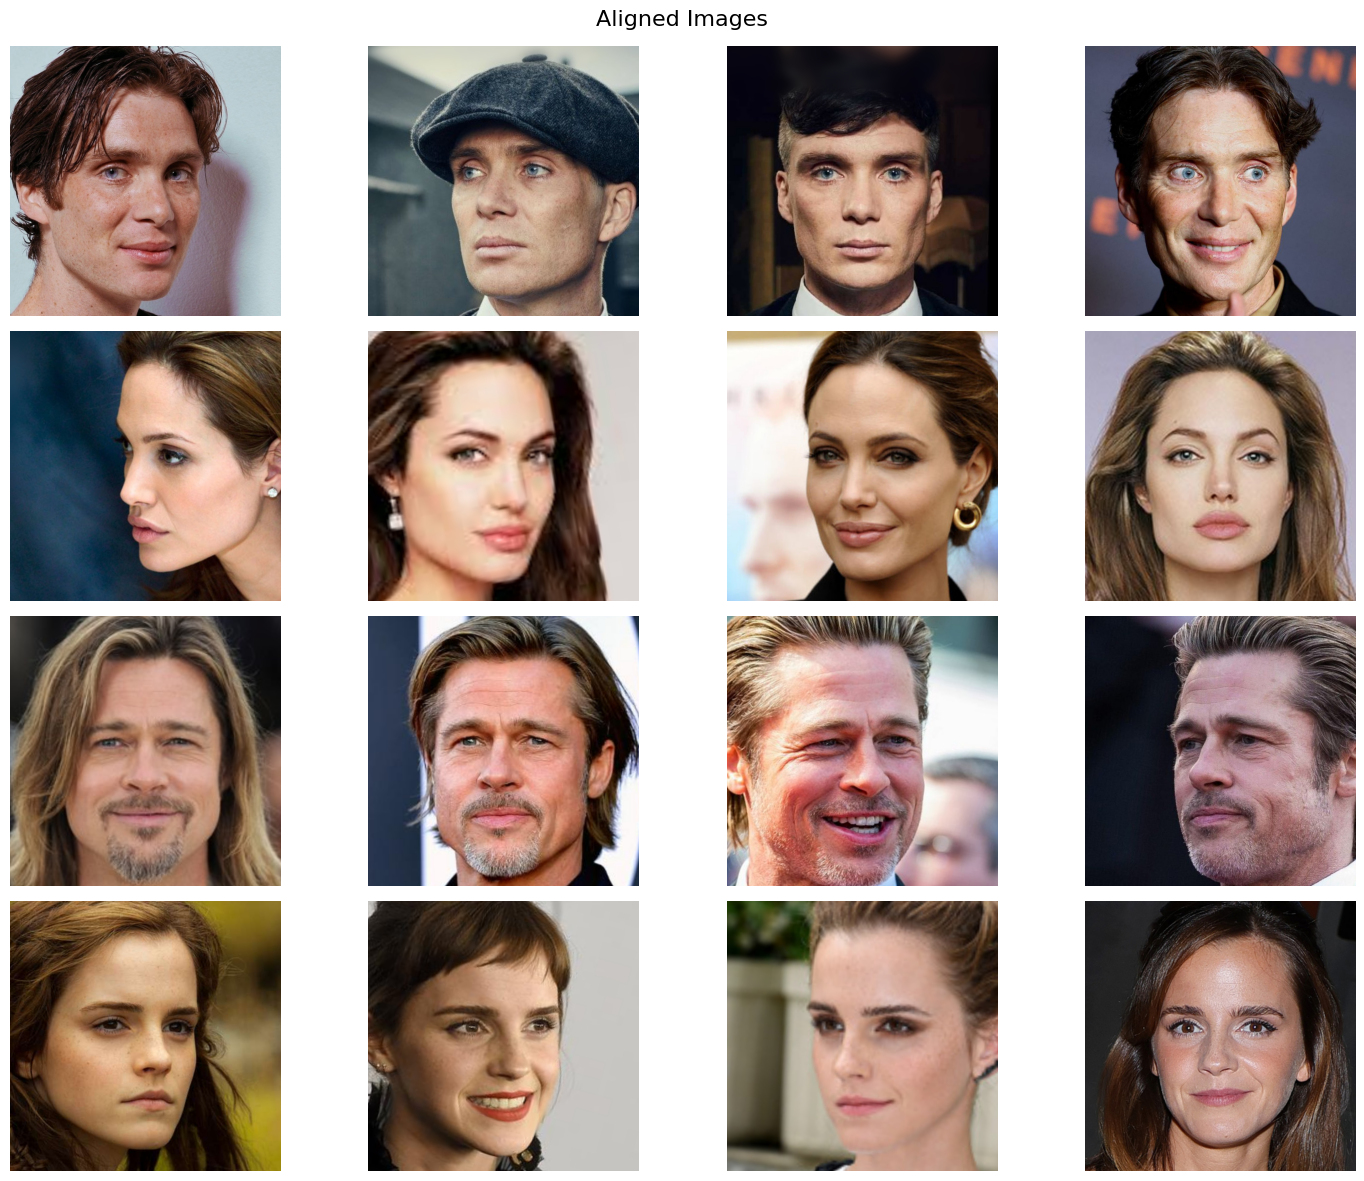

In [8]:
display_aligned_images(ALIGNED_IMAGES_DIR, num_images=4)

# Ищем проекцию разными методами

## Загрузка генератора

In [9]:
seed = 2345645
noise_mode = 'const'
label = 0
device = "cuda:0"
model_path = "./stylegan2-ada-pytorch/pretrained_models/ffhq.pkl"

with open(model_path, 'rb') as f:
    G = pickle.load(f)['G_ema'].cuda()

In [15]:
G

Generator(
  (synthesis): SynthesisNetwork(
    (b4): SynthesisBlock(
      (conv1): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (torgb): ToRGBLayer(
        (affine): FullyConnectedLayer()
      )
    )
    (b8): SynthesisBlock(
      (conv0): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (conv1): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (torgb): ToRGBLayer(
        (affine): FullyConnectedLayer()
      )
    )
    (b16): SynthesisBlock(
      (conv0): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (conv1): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (torgb): ToRGBLayer(
        (affine): FullyConnectedLayer()
      )
    )
    (b32): SynthesisBlock(
      (conv0): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (conv1): SynthesisLayer(
        (affine): FullyConnectedLayer()
      )
      (torgb): ToRGBLayer(
        (affine): FullyConn

## Берем средний вектор

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Rec_loss(nn.Module):
    def __init__(self, use_l1=True, use_ms_ssim=True):
        super().__init__()
        self.l1_criterion = torch.nn.L1Loss(reduction='mean')
        self.use_l1 = use_l1
        self.use_ms_ssim = use_ms_ssim

    def forward(self, target, synth):
        target = (target + 1.0) * 127.5 / 255
        synth = (synth + 1.0) * 127.5 / 255

        loss = 0
        if self.use_l1:
            loss += self.l1_criterion(synth, target)
        if self.use_ms_ssim:
            loss += torch.mean(1 - ms_ssim(synth, target, data_range=1, size_average=True))
        return loss

class Lpips_loss(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.lpips_loss = lpips.LPIPS(net='vgg').to(device).eval()

    def forward(self, target, synth):
        return torch.mean(self.lpips_loss(target, synth))

class Reg_loss(nn.Module):
    def __init__(self, noise_bufs):
        super().__init__()
        self.noise_bufs = noise_bufs

    def forward(self):
        reg_loss = 0.0
        for v in self.noise_bufs.values():
            noise = v[None,None,:,:]
            while True:
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=3)).mean()**2
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=2)).mean()**2
                if noise.shape[2] <= 8:
                    break
                noise = F.avg_pool2d(noise, kernel_size=2)
        return reg_loss

In [17]:
def image2tensor_norm(image):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    return transform(image).to(device).unsqueeze(0)

def broadcast_w_sg(w):
    if w.ndim == 2:
        return w.unsqueeze(1).repeat(1, G.mapping.num_ws, 1)
    return w

In [18]:
# image = ((image * std) + mean)
def plot_image(tensor, plot_size=(10,10)):
  tensor = (tensor.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  img = Image.fromarray(tensor[0].cpu().numpy(), 'RGB')
  plt.rcParams["figure.figsize"] = plot_size
  plt.imshow(img)


def broadcast_w_sg(w_batch, cast_n=18):
    input_ws = []
    for w in w_batch:
        w_broadcast = torch.broadcast_to(w, (cast_n, 512))
        input_ws.append(w_broadcast)
    return torch.stack(input_ws)


In [19]:
def save_projection_comparison(original_path, projection_result, output_path, title=""):

    original_img = Image.open(original_path).convert('RGB')
    original_tensor = transforms.ToTensor()(original_img)

    projected_tensor = projection_result['image'][0].cpu()

    grid = make_grid([original_tensor, projected_tensor], nrow=2, normalize=True, scale_each=True)

    plt.figure(figsize=(10, 5))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(title, fontsize=12)
    plt.axis('off')
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0.1, dpi=150)
    plt.close()

### добавила scheduler и early stopping

In [20]:
def project_image_exp1(
    target_image_path,
    G,
    num_steps=300,
    initial_lr=0.1,
    w_avg_samples=10000,
    seed=42,
    lpips_weight=1.0,
    rec_weight=0.5,
    noise_reg_weight=5e5,
    early_stop_patience=20,
    min_lr=1e-6,
    lr_reduce_factor=0.5,
    lr_patience=10,
    verbose=True
):
    target_pil = Image.open(target_image_path).convert('RGB')
    target_tensor = image2tensor_norm(target_pil)

    lpips_loss = Lpips_loss(device)
    rec_loss = Rec_loss()
    noise_bufs = {name: buf for name, buf in G.synthesis.named_buffers() if 'noise_const' in name}
    reg_loss = Reg_loss(noise_bufs)

    # Инициализация латентного вектора
    torch.manual_seed(seed)
    z_samples = torch.randn(w_avg_samples, G.z_dim, device=device)
    w_samples = G.mapping(z_samples, None)
    w_avg = torch.mean(w_samples[:, :1, :], dim=0, keepdim=True)
    w_opt = w_avg.clone().detach().requires_grad_(False)
    w_opt = broadcast_w_sg(w_opt).requires_grad_(True)


    optimizer = torch.optim.Adam([w_opt], lr=initial_lr, betas=(0.9, 0.999))
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=lr_reduce_factor,
        patience=lr_patience,
        min_lr=min_lr,
        # verbose=verbose
    )

    # Ранняя остановка
    best_loss = float('inf')
    best_w = None
    no_improve = 0

    progress = []
    print('start')
    for step in tqdm(range(num_steps), disable=not verbose):
        synth_tensor = G.synthesis(w_opt, noise_mode='const')

        lpips_value = lpips_loss(synth_tensor, target_tensor)
        rec_value = rec_loss(synth_tensor, target_tensor)
        reg_value = reg_loss()
        total_loss = lpips_weight*lpips_value + rec_weight*rec_value + noise_reg_weight*reg_value

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        scheduler.step(total_loss)

        progress.append({
            'step': step,
            'loss': total_loss.item(),
            'lr': optimizer.param_groups[0]['lr']
        })

        # Проверка ранней остановки
        if total_loss < best_loss:
            best_loss = total_loss
            best_w = w_opt.clone().detach()
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= early_stop_patience:
                if verbose:
                    print(f'\nEarly stopping at step {step}')
                break

    # Финальное изображение с лучшими весами
    with torch.no_grad():
         final_image = G.synthesis(broadcast_w_sg(w_opt), noise_mode='const', force_fp32=True)

    return {
        'w': best_w,
        'image': final_image,
        'progress': progress,
        'loss': best_loss.item()
    }

In [21]:
output_dir = "./outputs/projection_results/mean_vector/exp1/"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
celeb_folders = [f for f in glob(os.path.join(ALIGNED_IMAGES_DIR, "*")) if os.path.isdir(f)]

for folder in celeb_folders:
    celeb_name = os.path.basename(folder)
    print(f"\nОбработка папки: {celeb_name}")

    celeb_output_dir = os.path.join(output_dir, celeb_name)
    os.makedirs(celeb_output_dir, exist_ok=True)

    image_paths = glob(os.path.join(folder, "*.jp*g")) + glob(os.path.join(folder, "*.png"))

    for img_path in image_paths:
        img_name = os.path.basename(img_path)
        output_path = os.path.join(celeb_output_dir, f"projection_{img_name}")

        print(f"Обработка изображения: {img_name}")

        result = project_image_exp1(
            img_path,
            G,
            num_steps=500,
            initial_lr=0.05,
            lpips_weight=0.8,
            rec_weight=1.0,
            noise_reg_weight=1e5,
            early_stop_patience=30,
            verbose=False
        )

        save_image(result['image'], os.path.join(celeb_output_dir,img_name), normalize=True)
        save_projection_comparison(
            img_path,
            result,
            output_path,
            title=f"exp1: {celeb_name} - Original vs Projection"
        )

### Относительно прошлого эксперимента поменяла веса у лоссов

'lpips_weight': 1.2,

#### Увеличила lpips_weight

In [22]:
output_dir = "./outputs/projection_results/mean_vector/exp2/"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
os.makedirs(output_dir, exist_ok=True)
celeb_folders = [f for f in glob(os.path.join(ALIGNED_IMAGES_DIR, "*")) if os.path.isdir(f)]

for folder in celeb_folders:
    celeb_name = os.path.basename(folder)
    print(f"\nОбработка папки: {celeb_name}")

    celeb_output_dir = os.path.join(output_dir, celeb_name)
    os.makedirs(celeb_output_dir, exist_ok=True)

    image_paths = glob(os.path.join(folder, "*.jp*g")) + glob(os.path.join(folder, "*.png"))

    for img_path in image_paths:
        img_name = os.path.basename(img_path)
        output_path = os.path.join(celeb_output_dir, f"projection_{img_name}")


        print(f"Обработка изображения: {img_name}")

        result = project_image_exp1(
            img_path,
            G,
            num_steps=500,
            initial_lr=0.05,
            lpips_weight=1.2,
            rec_weight=1.0,
            noise_reg_weight=1e5,
            early_stop_patience=30,
            verbose=False
        )

        save_image(result['image'], os.path.join(celeb_output_dir,img_name), normalize=True)
        save_projection_comparison(
            img_path,
            result,
            output_path,
            title=f"exp2: {celeb_name} - Original vs Projection"
        )

##  Энкодер

In [23]:
from stylegan2_models.e4e.model_utils import load_e4e_standalone
import torchvision.transforms as transforms

e4e_model, _ = load_e4e_standalone("./stylegan2-ada-pytorch/pretrained_models/e4e_ffhq_encode.pt")

In [24]:
e4e_model

Encoder4Editing(
  (input_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=64)
  )
  (body): Sequential(
    (0): bottleneck_IR_SE(
      (shortcut_layer): MaxPool2d(kernel_size=1, stride=2, padding=0, dilation=1, ceil_mode=False)
      (res_layer): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (2): PReLU(num_parameters=64)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): SEModule(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [ ]:
output_dir = "./outputs/projection_results/encoder/exp1/"
# output_dir = "./projection_results/encoder/exp1/"

os.makedirs(output_dir, exist_ok=True)

In [26]:
def project_with_e4e(
    target_image_path,
    G,
    e4e_model,
    num_steps=300,
    initial_lr=0.01,
    lpips_weight=1.0,
    rec_weight=0.5,
    noise_reg_weight=5e5,
    early_stop_patience=20,
    min_lr=1e-6,
    lr_reduce_factor=0.5,
    lr_patience=10,
    verbose=True
):
    target_pil = Image.open(target_image_path).convert('RGB')
    target_uint8 = np.array(target_pil, dtype=np.uint8)

    e4e_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((256, 256)),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    e4e_tensor = e4e_transform(target_uint8).to(device).unsqueeze(0)
    with torch.no_grad():
        initial_latent = e4e_model(e4e_tensor)

    target_tensor = transforms.Resize(G.img_resolution)(e4e_tensor)

    w_opt = nn.Parameter(initial_latent.clone(), requires_grad=True)

    lpips_loss = Lpips_loss(device)
    rec_loss = Rec_loss()
    noise_bufs = {name: buf for name, buf in G.synthesis.named_buffers() if 'noise_const' in name}
    reg_loss = Reg_loss(noise_bufs)

    optimizer = torch.optim.Adam([w_opt], lr=initial_lr, betas=(0.9, 0.999))
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=lr_reduce_factor,
        patience=lr_patience,
        min_lr=min_lr,
        verbose=verbose
    )

    best_loss = float('inf')
    best_w = None
    no_improve = 0

    progress = []
    for step in tqdm(range(num_steps), disable=not verbose):
        synth_tensor = G.synthesis(w_opt, noise_mode='const')

        lpips_value = lpips_loss(synth_tensor, target_tensor)
        rec_value = rec_loss(synth_tensor, target_tensor)
        reg_value = reg_loss()
        total_loss = lpips_weight*lpips_value + rec_weight*rec_value + noise_reg_weight*reg_value

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        scheduler.step(total_loss)

        progress.append({
            'step': step,
            'loss': total_loss.item(),
            'lr': optimizer.param_groups[0]['lr']
        })

        if total_loss < best_loss:
            best_loss = total_loss
            best_w = w_opt.clone().detach()
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= early_stop_patience:
                if verbose:
                    print(f'\nEarly stopping at step {step}')
                break

    with torch.no_grad():
        final_image = G.synthesis(best_w, noise_mode='const', force_fp32=True)

    return {
        'w': best_w,
        'image': final_image,
        'progress': progress,
        'loss': best_loss.item()
    }

In [ ]:
os.makedirs(output_dir, exist_ok=True)
celeb_folders = [f for f in glob(os.path.join(ALIGNED_IMAGES_DIR, "*")) if os.path.isdir(f)]

for folder in celeb_folders:
    celeb_name = os.path.basename(folder)
    print(f"\nОбработка папки: {celeb_name}")

    celeb_output_dir = os.path.join(output_dir, celeb_name)
    os.makedirs(celeb_output_dir, exist_ok=True)

    image_paths_ = glob(os.path.join(folder, "*.jp*g")) + glob(os.path.join(folder, "*.png"))
    image_paths = image_paths_[:1]
    print(image_paths)

    for img_path in image_paths:
        img_name = os.path.basename(img_path)
        output_path = os.path.join(celeb_output_dir, f"projection_{img_name}")


        print(f"Обработка изображения: {img_path}")

        result = project_with_e4e(
            img_path,
            G,
            e4e_model,
            num_steps=500,
            initial_lr=0.05,
            lpips_weight=1.2,
            rec_weight=1.0,
            noise_reg_weight=1e5,
            early_stop_patience=30,
            verbose=False
        )

        save_image(result['image'], os.path.join(celeb_output_dir,img_name), normalize=True)
        save_projection_comparison(
            img_path,
            result,
            output_path,
            title=f"Encoder exp1: {celeb_name} - Original vs Projection"
        )


Обработка папки: merphy
['./data/aligned_images/merphy/1.jpg']
Обработка изображения: ./data/aligned_images/merphy/1.jpg
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /ssd/a.gorokhova/usr/anaconda3/envs/genmodels/lib/python3.11/site-packages/lpips/weights/v0.1/vgg.pth
Setting up PyTorch plugin "bias_act_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... Failed!
Setting up PyTorch plugin "upfirdn2d_plugin"... 

# Style transfer

In [ ]:
landmarks_model_path = "./stylegan2-ada-pytorch/pretrained_models/shape_predictor_68_face_landmarks.dat"
RAW_STYLES_IMAGES_DIR = "./data/styles_imgs"
ALIGNED_STYLES_IMAGES_DIR = "./data/aligned_style_images"

In [ ]:
landmarks_detector = LandmarksDetector(landmarks_model_path)
for style in os.listdir(RAW_STYLES_IMAGES_DIR):
  save_path = os.path.join(ALIGNED_STYLES_IMAGES_DIR, style)
  os.makedirs(ALIGNED_STYLES_IMAGES_DIR, exist_ok=True)
  # for i, img_name in enumerate(os.listdir(celeb_folder)):
  if style == ".ipynb_checkpoints":
    continue
  raw_style_img_path = os.path.join(RAW_STYLES_IMAGES_DIR, style)
  print(raw_style_img_path, save_path)
  for face_landmarks in landmarks_detector.get_landmarks(raw_style_img_path):
      # aligned_style_path = os.path.join(save_path, f"{style}")
      image_align(raw_style_img_path, save_path, face_landmarks)
      break

In [ ]:
def style_transfer_latent(content_img_path, style_img_path, G, e4e_model=None, alpha=0.5, steps=300):
    content_proj = project_with_e4e(
        content_img_path,
        G,
        e4e_model,
        num_steps=500,
        initial_lr=0.05,
        lpips_weight=1.2,
        rec_weight=1.0,
        noise_reg_weight=1e5,
        early_stop_patience=30,
        verbose=False) if e4e_model else project_image_exp1(content_img_path, G)
    style_proj = project_with_e4e(
        style_img_path,
        G,
        e4e_model,
        num_steps=500,
        initial_lr=0.05,
        lpips_weight=1.2,
        rec_weight=1.0,
        noise_reg_weight=1e5,
        early_stop_patience=30,
        verbose=False) if e4e_model else project_image_exp1(style_img_path, G)

    mixed_w = (1-alpha)*content_proj['w'] + alpha*style_proj['w']

    with torch.no_grad():
        result = G.synthesis(mixed_w, noise_mode='const')

    return result

In [ ]:
output_dir = "./outputs/style_transfer_results/exp1/"
os.makedirs(output_dir, exist_ok=True)

celeb_folders = [f for f in glob(os.path.join(ALIGNED_IMAGES_DIR, "*")) if os.path.isdir(f)]
styles_transfer = [os.path.join(ALIGNED_STYLES_IMAGES_DIR, file) for file in os.listdir(ALIGNED_STYLES_IMAGES_DIR)]
print(styles_transfer)

In [ ]:
for folder in celeb_folders:
    celeb_name = os.path.basename(folder)
    print(f"\nОбработка папки: {celeb_name}")

    celeb_output_dir = os.path.join(output_dir, celeb_name)
    os.makedirs(celeb_output_dir, exist_ok=True)

    image_paths = glob(os.path.join(folder, "*.jp*g")) + glob(os.path.join(folder, "*.png"))
    image_paths = image_paths[:1]

    for img_path in image_paths:
      print(f"Обработка изображения: {img_path}")
      for style_path in styles_transfer:
        print(f"Применение стиля: {style_path}")

        img_name = os.path.basename(img_path).split('.')[0]
        style_name = os.path.basename(style_path).split('.')[0]
        output_path_res = os.path.join(celeb_output_dir, f"transfer_{img_name}_{style_name}.jpg")

        result = style_transfer_latent(img_path, style_path, G, e4e_model, alpha=0.4, steps=300)
        save_image(result, output_path_res, normalize=True)

# Expression Transfer

In [ ]:
def expression_transfer_latent(target_img_path, G, e4e_model=None,
                             expression_direction_path=None, expression_img_path=None, psi=0.5,
                             indices=[4], steps=300):

    # Project target image
    target_proj = project_with_e4e(
        target_img_path,
        G,
        e4e_model,
        num_steps=steps,
        initial_lr=0.05,
        lpips_weight=1.2,
        rec_weight=1.0,
        noise_reg_weight=1e5,
        early_stop_patience=30,
        verbose=False) if e4e_model else project_image_exp1(target_img_path, G)

    if expression_direction_path:
        expr_direction = torch.load(expression_direction_path).to(device)
        expr_direction = broadcast_w_sg(expr_direction)
    else:
        expr_proj = project_with_e4e(
            expression_img_path,
            G,
            e4e_model,
            num_steps=steps,
            initial_lr=0.05,
            lpips_weight=1.2,
            rec_weight=1.0,
            noise_reg_weight=1e5,
            early_stop_patience=30,
            verbose=False) if e4e_model else project_image_exp1(expression_img_path, G)
        expr_direction = expr_proj['w'] - target_proj['w']

    mixed_w = target_proj['w'].clone()
    for i in indices:
        mixed_w[:, i] = target_proj['w'][:, i] + psi * expr_direction[:, i]

    with torch.no_grad():
        result = G.synthesis(mixed_w, noise_mode='const')

    return result

In [ ]:
output_dir = "./outputs/expression_transfer_results/exp1/"
os.makedirs(output_dir, exist_ok=True)

celeb_folders = [f for f in glob(os.path.join(ALIGNED_IMAGES_DIR, "*")) if os.path.isdir(f)]
expr_transfer = [os.path.join('./editing/', f) for f in os.listdir("./editing/")]
print(expr_transfer)

In [ ]:
for folder in celeb_folders:
    celeb_name = os.path.basename(folder)
    print(f"\nОбработка папки: {celeb_name}")

    celeb_output_dir = os.path.join(output_dir, celeb_name)
    os.makedirs(celeb_output_dir, exist_ok=True)
    # print(celeb_output_dir)

    image_paths = glob(os.path.join(folder, "*.jp*g")) + glob(os.path.join(folder, "*.png"))
    image_paths = image_paths[:1]

    for img_path in image_paths:
      print(f"Обработка изображения: {img_path}")
      for expr_path in expr_transfer:
        img_name = os.path.basename(img_path).split('.')[0]
        expr_name = os.path.basename(expr_path).split('.')[0]
        output_path_res = os.path.join(celeb_output_dir, f"expression_{img_name}_{expr_name}.jpg")

        result = expression_transfer_latent(img_path, G, e4e_model, expression_direction_path=expr_path, psi=3, indices=[4,5,6], steps=400)
        save_image(result, output_path_res, normalize=True)

# Face swap

In [ ]:
import PIL
import os
import numpy as np
import torch
import lpips
import torch.nn as nn
import torchvision.transforms as transforms
from pytorch_msssim import ms_ssim
from stylegan2_models.arcface_model import get_model
import torch.nn.functional as F
from stylegan2_models.e4e.model_utils import load_e4e_standalone
import torchvision.transforms as transforms


def image2tensor_norm(image):
    transform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    tensor = transform(image)
    return tensor



class Arcface_Loss(nn.Module):
    def __init__(self, weights_path, device):
        super().__init__()

        self.arcnet = get_model("r50", fp16=False)
        self.arcnet.load_state_dict(torch.load(weights_path))
        self.arcnet.eval()
        self.arcnet.to(device)

        self.cosin_loss = nn.CosineSimilarity(dim=1, eps=1e-6)

    def forward(self, source, synth):

        source = F.interpolate(source,size=(112,112), mode='bicubic')
        synth = F.interpolate(synth,size=(112,112), mode='bicubic')

        emb1 = self.arcnet(source)
        emb2 = self.arcnet(synth)
        loss = (1 - self.cosin_loss(emb1, emb2))[0]
        return loss

In [ ]:
def face_swap_with_arcface(
    target_image_path,
    identity_image_path,
    G,
    e4e_model,
    arcface_weights_path,
    num_steps=500,
    initial_lr=0.01,
    lpips_weight=1.0,
    rec_weight=0.5,
    identity_weight=2.0,
    noise_reg_weight=5e5,
    early_stop_patience=30,
    min_lr=1e-6,
    lr_reduce_factor=0.5,
    lr_patience=10,
    verbose=True
):
    target_pil = Image.open(target_image_path).convert('RGB')
    identity_pil = Image.open(identity_image_path).convert('RGB')

    target_uint8 = np.array(target_pil, dtype=np.uint8)
    identity_uint8 = np.array(identity_pil, dtype=np.uint8)

    e4e_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((256, 256)),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    e4e_tensor = e4e_transform(target_uint8).to(device).unsqueeze(0)
    with torch.no_grad():
        initial_latent = e4e_model(e4e_tensor)

    target_tensor = transforms.Resize(G.img_resolution)(e4e_tensor)
    identity_tensor = image2tensor_norm(identity_uint8).to(device).unsqueeze(0)
    identity_tensor = transforms.Resize(G.img_resolution)(identity_tensor)

    w_opt = nn.Parameter(initial_latent.clone(), requires_grad=True)

    lpips_loss = Lpips_loss(device)
    rec_loss = Rec_loss()
    arcface_loss = Arcface_Loss(arcface_weights_path, device)
    noise_bufs = {name: buf for name, buf in G.synthesis.named_buffers() if 'noise_const' in name}
    reg_loss = Reg_loss(noise_bufs)

    optimizer = torch.optim.Adam([w_opt], lr=initial_lr, betas=(0.9, 0.999))
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=lr_reduce_factor,
        patience=lr_patience,
        min_lr=min_lr,
        verbose=verbose
    )

    best_loss = float('inf')
    best_w = None
    no_improve = 0

    progress = []
    for step in tqdm(range(num_steps), disable=not verbose):
        synth_tensor = G.synthesis(w_opt, noise_mode='const')

        lpips_value = lpips_loss(synth_tensor, target_tensor)
        rec_value = rec_loss(synth_tensor, target_tensor)
        identity_value = arcface_loss(identity_tensor, synth_tensor)
        reg_value = reg_loss()

        total_loss = (lpips_weight * lpips_value +
                     rec_weight * rec_value +
                     identity_weight * identity_value +
                     noise_reg_weight * reg_value)

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        scheduler.step(total_loss)

        progress.append({
            'step': step,
            'loss': total_loss.item(),
            'lpips': lpips_value.item(),
            'rec': rec_value.item(),
            'identity': identity_value.item(),
            'reg': reg_value.item(),
            'lr': optimizer.param_groups[0]['lr']
        })

        if total_loss < best_loss:
            best_loss = total_loss
            best_w = w_opt.clone().detach()
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= early_stop_patience:
                if verbose:
                    print(f'\nEarly stopping at step {step}')
                break

    with torch.no_grad():
        final_image = G.synthesis(best_w, noise_mode='const', force_fp32=True)

    return {
        'w': best_w,
        'image': final_image,
        'progress': progress,
        'loss': best_loss.item()
    }

In [ ]:
arcface_path = "./stylegan2-ada-pytorch/ms1mv3_arcface_r50_fp16.pth"
output_dir = "./outputs/faceswap_results/exp1/"
os.makedirs(output_dir, exist_ok=True)


celeb_images = []
for celeb_folder in celeb_folders:
  imgs = os.listdir(celeb_folder)
  celeb_images.append(os.path.join(celeb_folder, imgs[0]))

In [ ]:
for target_path in celeb_images:
    folder_name = target_path.split('/')[-2]
    target_name = f'{folder_name}{os.path.basename(target_path)}'
    target_name = target_name.split('.')[0]

    for ident_path in celeb_images:
      if ident_path == target_path:
        continue
      folder_ident_name = ident_path.split('/')[-2]
      ident_name = f'{folder_ident_name}{os.path.basename(ident_path)}'
      output_path = os.path.join(output_dir, f"faceswap_{target_name}_{ident_name}")
      print(f"Обработка изображения {target_name} с {ident_name}")

      result = face_swap_with_arcface(
          target_image_path=target_path,
          identity_image_path=ident_path,
          G=G,
          e4e_model=e4e_model,
          arcface_weights_path=arcface_path,
          num_steps=400,
          identity_weight=5.0,
          verbose=False,
      )

      save_image(result['image'], output_path, normalize=True)